# Microsoft Rice Leaf Disease Classification

In [ ]:
# Import the necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import argparse
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import optim
from torch.utils.data.dataset import random_split
from torchvision import transforms
from tqdm import tqdm
import cv2
import os
from pathlib import Path
import torch
#from imutils import paths
from torchvision.models import resnet50
import torch.nn as nn
import torchvision.models as models
import time
from torch.nn import functional as F

# Set to avoid receiving warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


### Exploratory Data Analysis

In [ ]:
#  Loading the train images id data
train = pd.read_csv('/kaggle/input/rice-leaf-desease-classification/Train.csv')
train.drop(train[train.index %2 != 0].index, inplace=True) # Selecting only the RGB images
train.reset_index(inplace=True,drop=True) # Reseting the indeces to start from 0
train.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_005sitfgr2.jpg,brown
2,id_00stp9t6m6.jpg,blast
3,id_012zxewnhx.jpg,blast
4,id_0186qwq2at.jpg,healthy


In [ ]:
train['Label'].value_counts()

Label
blast      1494
brown       766
healthy     410
Name: count, dtype: int64

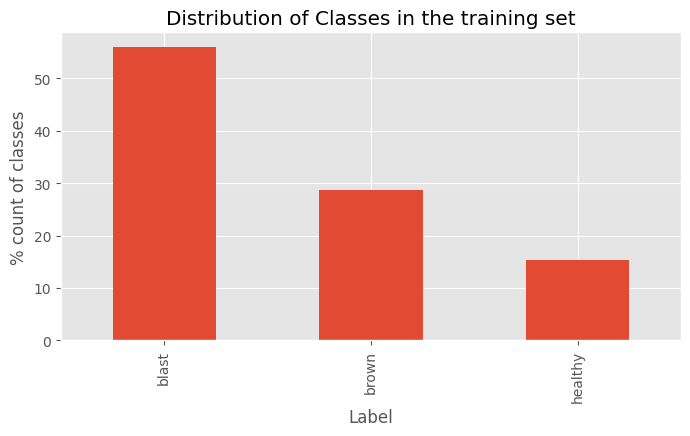

In [ ]:
figure = plt.figure(figsize=(8,4))
(train['Label'].value_counts()/len(train)*100).plot(kind='bar')
plt.title("Distribution of Classes in the training set")
plt.ylabel('% count of classes')
plt.show()

In [ ]:
tot_len = len(train)
class_weights = train['Label'].value_counts()
class_weights = tot_len/class_weights
class_weights = class_weights.to_dict()
class_weights = {k:v for k,v in sorted(class_weights.items()) }
class_weights

{'blast': 1.78714859437751,
 'brown': 3.485639686684073,
 'healthy': 6.512195121951219}

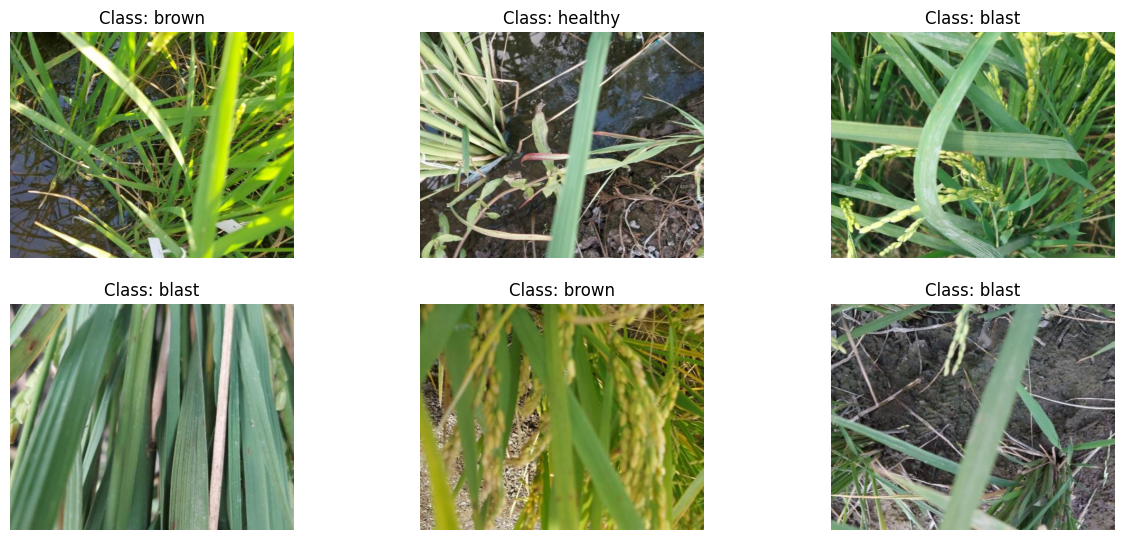

In [ ]:
# Sampling some images of CMD in the dataset
def show_image(image_ids, labels):
    plt.figure(figsize=(15,10))

    for i, (image_id,label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3,3,i+1)
        img = cv2.imread(os.path.join('/kaggle/input/rice-leaf-desease-classification/Images', image_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")

    plt.show()


samples = train.sample(6, random_state = 9417)
image_ids = samples['Image_id'].values
labels = samples['Label'].values

show_image(image_ids, labels)

## Residual Network 50 (resnet50)

### Setting the necessary paramters

In [ ]:
batch_size = 256
num_epochs = 20
num_classes = 3
lr_rate = 0.001
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
Pred_BS = 4
BS_ft = 64
lr_ft = 0.001

In [ ]:
X = np.array(train['Image_id']) # the features variable
y = np.array(train['Label']) # the target variable

In [ ]:
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
image_paths = '/kaggle/input/rice-leaf-desease-classification/Images/' # path to load the images

# Constructing the training and validation images
tr_images = image_paths + X_train
val_images = image_paths + X_val

In [ ]:
# Encoding the labels
label_pred = {'blast' : 0, 'brown' : 1, 'healthy': 2}

pred_label = {0: 'blast', 1: 'brown', 2: 'healthy'}

In [ ]:
# Function to create a dataset
class RiceDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=None):

        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224), Image.LANCZOS)

        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)

        label = self.labels[idx]
        label = np.array(label2pred[label])
        label = torch.tensor(label)

        if self.transforms:
            image = self.transforms(image)

        return image, label

In [ ]:
# define augmentation pipelines
trainTansform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.RandomRotation(90),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=MEAN, std=STD)])

valTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

In [ ]:
# Dataset creation
train_dataset = RiceDataset(image_paths=tr_images, labels=y_train, transforms=trainTansform)
val_dataset = RiceDataset(image_paths=val_images, labels=y_val, transforms=valTransform)

# Print the size of dataset
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Train dataset size: 1869
Validation dataset size: 801


'blast'

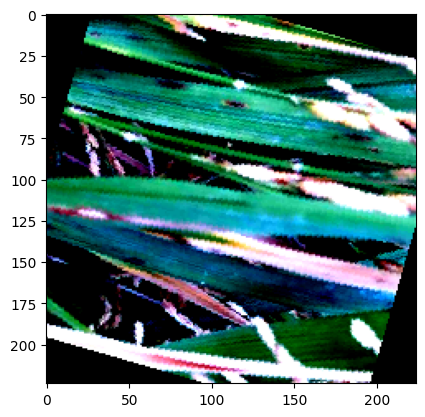

In [ ]:
image, label = train_dataset[2]

plt.imshow(image.permute(1, 2, 0))
pred_label[label.item()]

'blast'

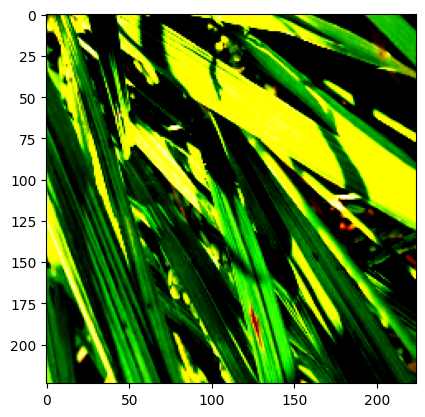

In [ ]:
img, label = val_dataset[2]

plt.imshow(img.permute(1, 2, 0))
pred_label[label.item()]

In [ ]:
train_dataloaders = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloaders = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
next(iter(val_dataloaders))[0].shape, next(iter(val_dataloaders))[1].shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

In [ ]:
next(iter(train_dataloaders))[0].shape, next(iter(train_dataloaders))[1].shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

In [ ]:
# Load pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze all parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_classes = 3  # The number of classes in my dataset
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Move the modified ResNet50 model to the device
resnet50 = resnet50.to(device)

In [ ]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)
label_codes = {'blast': 0, 'brown': 1, 'healthy': 2}
# Apply the mapping to the keys of the dictionary
class_weight = {label_codes[key]: value for key, value in class_weights.items()}
weights = torch.tensor(list(class_weight.values()), dtype=torch.float32)
lossFunc = nn.CrossEntropyLoss(weight=weights)

opt = optim.Adam(resnet50.parameters(), lr=lr_rate)
#opt = optim.SGD(model.parameters(), lr=lr_rate, momentum=0.9)

train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)

# calculate steps per epoch for training and validation set
trainSteps = train_dataset_size // batch_size
valSteps = val_dataset_size // batch_size

# initialize a dictionary to store training history
History = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

### Training and evaluation of the residual network 50

In [ ]:
print("[Training Started...")
startTime = time.time()
# loop over epochs
for j in tqdm(range(num_epochs)):
    # set the model in training mode
    resnet50.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dataloaders):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device).long())

        # perform a forward pass and calculate the training loss
        pred = resnet50(x)
        loss = lossFunc(pred, y)
        # calculate the gradients
        loss.backward()
        # check if we are updating the model parameters and if so
        # update them, and zero out the previously accumulated gradients
        if (i + 2) % 2 == 0:
            opt.step()
            opt.zero_grad()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        resnet50.eval()
        # loop over the validation set
        for (x, y) in val_dataloaders:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = resnet50(x)
            totalValLoss += lossFunc(pred, y)
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / train_dataset_size
    valCorrect = valCorrect / val_dataset_size
    # update our training history
    History["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    History["train_acc"].append(trainCorrect)
    History["val_loss"].append(avgValLoss.cpu().detach().numpy())
    History["val_acc"].append(valCorrect)
    # print the model training and validation information
    print("TOTAL EPOCH: {}/{}".format(j + 1, num_epochs))
    print("Train loss: {:.4f}, Train accuracy: {:.2f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.4f}, Val accuracy: {:.2f}".format(avgValLoss, valCorrect))

print('Finished Training')

# Display the total time needed to perform the training
endTime = time.time()
print("The total time taken to train the model: {:.2f}s".format(endTime - startTime))

[Training Started...


  5%|▌         | 1/20 [08:07<2:34:19, 487.33s/it]

TOTAL EPOCH: 1/20
Train loss: 1.2865, Train accuracy: 0.38
Val loss: 1.4577, Val accuracy: 0.60


 10%|█         | 2/20 [16:07<2:25:01, 483.40s/it]

TOTAL EPOCH: 2/20
Train loss: 1.1727, Train accuracy: 0.44
Val loss: 1.3501, Val accuracy: 0.38


 15%|█▌        | 3/20 [24:00<2:15:33, 478.47s/it]

TOTAL EPOCH: 3/20
Train loss: 1.1031, Train accuracy: 0.55
Val loss: 1.2214, Val accuracy: 0.68


 20%|██        | 4/20 [32:11<2:08:53, 483.32s/it]

TOTAL EPOCH: 4/20
Train loss: 1.0509, Train accuracy: 0.60
Val loss: 1.1748, Val accuracy: 0.55


 25%|██▌       | 5/20 [40:15<2:00:53, 483.56s/it]

TOTAL EPOCH: 5/20
Train loss: 0.9954, Train accuracy: 0.62
Val loss: 1.1367, Val accuracy: 0.70


 30%|███       | 6/20 [48:19<1:52:50, 483.61s/it]

TOTAL EPOCH: 6/20
Train loss: 0.9552, Train accuracy: 0.68
Val loss: 1.0909, Val accuracy: 0.61


 35%|███▌      | 7/20 [56:24<1:44:53, 484.10s/it]

TOTAL EPOCH: 7/20
Train loss: 0.9255, Train accuracy: 0.68
Val loss: 1.0430, Val accuracy: 0.69


 40%|████      | 8/20 [1:04:22<1:36:27, 482.26s/it]

TOTAL EPOCH: 8/20
Train loss: 0.8931, Train accuracy: 0.70
Val loss: 1.0468, Val accuracy: 0.67


 45%|████▌     | 9/20 [1:12:25<1:28:28, 482.61s/it]

TOTAL EPOCH: 9/20
Train loss: 0.8848, Train accuracy: 0.69
Val loss: 1.0818, Val accuracy: 0.70


 50%|█████     | 10/20 [1:20:30<1:20:33, 483.34s/it]

TOTAL EPOCH: 10/20
Train loss: 0.8553, Train accuracy: 0.73
Val loss: 1.0089, Val accuracy: 0.69


 55%|█████▌    | 11/20 [1:28:33<1:12:27, 483.10s/it]

TOTAL EPOCH: 11/20
Train loss: 0.8376, Train accuracy: 0.69
Val loss: 1.0124, Val accuracy: 0.70


 60%|██████    | 12/20 [1:36:30<1:04:10, 481.26s/it]

TOTAL EPOCH: 12/20
Train loss: 0.8208, Train accuracy: 0.75
Val loss: 1.0113, Val accuracy: 0.74


 65%|██████▌   | 13/20 [1:44:37<56:21, 483.01s/it]  

TOTAL EPOCH: 13/20
Train loss: 0.8109, Train accuracy: 0.68
Val loss: 0.9733, Val accuracy: 0.66


 70%|███████   | 14/20 [1:52:38<48:14, 482.38s/it]

TOTAL EPOCH: 14/20
Train loss: 0.8205, Train accuracy: 0.72
Val loss: 0.9589, Val accuracy: 0.77


 75%|███████▌  | 15/20 [2:00:43<40:15, 483.08s/it]

TOTAL EPOCH: 15/20
Train loss: 0.8098, Train accuracy: 0.70
Val loss: 1.0373, Val accuracy: 0.63


 80%|████████  | 16/20 [2:08:49<32:15, 484.00s/it]

TOTAL EPOCH: 16/20
Train loss: 0.7964, Train accuracy: 0.71
Val loss: 0.9657, Val accuracy: 0.77


 85%|████████▌ | 17/20 [2:16:43<24:03, 481.18s/it]

TOTAL EPOCH: 17/20
Train loss: 0.8225, Train accuracy: 0.75
Val loss: 0.9289, Val accuracy: 0.72


 90%|█████████ | 18/20 [2:24:37<15:57, 478.79s/it]

TOTAL EPOCH: 18/20
Train loss: 0.7898, Train accuracy: 0.71
Val loss: 0.9006, Val accuracy: 0.74


 95%|█████████▌| 19/20 [2:32:39<07:59, 479.79s/it]

TOTAL EPOCH: 19/20
Train loss: 0.7786, Train accuracy: 0.76
Val loss: 0.9238, Val accuracy: 0.75


100%|██████████| 20/20 [2:40:41<00:00, 482.08s/it]

TOTAL EPOCH: 20/20
Train loss: 0.7644, Train accuracy: 0.73
Val loss: 0.9387, Val accuracy: 0.69
Finished Training
The total time taken to train the model: 9641.52s


### Visualizing the performance of the Model during Training and Evaluation Phase

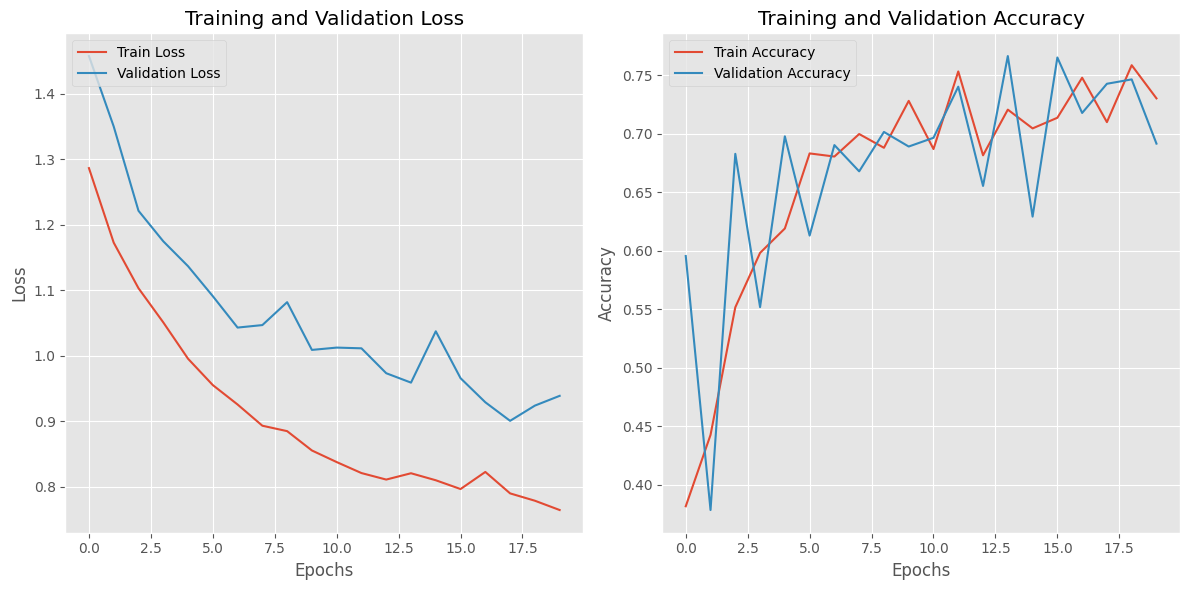

In [ ]:
# Plot the training and validation loss
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(History["train_loss"], label="Train Loss")
plt.plot(History["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(History["train_acc"], label="Train Accuracy")
plt.plot(History["val_acc"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

From the plot above, we can see that the model did not perform well. We are going to fine-tune it by changing some parameters.

### Fine-tuning of the pretrained model

In [ ]:
# define augmentation pipelines
train_Tansform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.RandomRotation(90),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=MEAN, std=STD)
])
val_Transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

In [ ]:
class RiceDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=None):

        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224), Image.LANCZOS)

        label = self.labels[idx]
        label = np.array(label2pred[label])
        label = torch.tensor(label)

        if self.transforms:
            image = self.transforms(image)

        return image, label

In [ ]:
train_data = RiceDataset(image_paths=tr_images, labels=y_train, transforms=train_Tansform)
val_data = RiceDataset(image_paths=val_images, labels=y_val, transforms=val_Transform)

# Print the size of dataset
print(f'Train dataset size: {len(train_data)}')
print(f'Validation dataset size: {len(val_data)}')

Train dataset size: 1869
Validation dataset size: 801


In [ ]:
trainLoader = DataLoader(train_data, batch_size=BS_ft, shuffle=True)
valLoader = DataLoader(val_data, batch_size=BS_ft, shuffle=True)

In [ ]:
# load up the ResNet50 model
resnet50 = models.resnet50(pretrained=True)
numFeatures = resnet50.fc.in_features
# loop over the modules of the model and set the parameters of
# batch normalization modules as not trainable
for module, param in zip(resnet50.modules(), resnet50.parameters()):
    if isinstance(module, nn.BatchNorm2d):
        param.requires_grad = False
# define the network head and attach it to the model
Model = nn.Sequential(
    nn.Linear(numFeatures, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
resnet50.fc = Model
# append a new classification top to our feature extractor and pop it
# on to the current device
resnet50 = resnet50.to(device)

In [ ]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)
label_codes = {'blast': 0, 'brown': 1, 'healthy': 2}
# Apply the mapping to the keys of the dictionary
class_weight = {label_codes[key]: value for key, value in class_weights.items()}
weights = torch.tensor(list(class_weight.values()), dtype=torch.float32)
lossFunc = nn.CrossEntropyLoss(weight=weights)
opt = torch.optim.Adam(resnet50.parameters(), lr=lr_ft)

# calculate steps per epoch for training and validation set
tr_steps = len(train_data) // BS_ft
v_steps = len(val_data) // BS_ft

# initialize a dictionary to store training history
Hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

In [ ]:
# loop over epochs
print("[ Fine-tuning started...")
start_time = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    resnet50.train()
    # initialize the total training and validation loss
    tot_train_loss = 0
    tot_val_loss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    tr_correct = 0
    v_correct = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device).long())

        # perform a forward pass and calculate the training loss
        pred = resnet50(x)
        loss = lossFunc(pred, y)
        # calculate the gradients
        loss.backward()
        # check if we are updating the model parameters and if so
        # update them, and zero out the previously accumulated gradients
        if (i + 2) % 2 == 0:
            opt.step()
            opt.zero_grad()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        tot_train_loss += loss
        tr_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        resnet50.eval()

        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device).long())

            # make the predictions and calculate the validation loss
            pred = resnet50(x)
            tot_val_loss += lossFunc(pred, y)

            # calculate the number of correct predictions
            v_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # calculate the average training and validation loss
    train_avg_loss = tot_train_loss / tr_steps
    val_avg_loss = tot_val_loss / v_steps

    # calculate the training and validation accuracy
    tr_correct = tr_correct / len(train_data)
    v_correct = v_correct / len(val_data)

    # update our training history
    Hist["train_loss"].append(train_avg_loss.cpu().detach().numpy())
    Hist["train_acc"].append(tr_correct)
    Hist["val_loss"].append(val_avg_loss.cpu().detach().numpy())
    Hist["val_acc"].append(v_correct)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.4f}, Train accuracy: {:.2f}".format(train_avg_loss, tr_correct))
    print("Val loss: {:.4f}, Val accuracy: {:.2f}".format(val_avg_loss, v_correct))

print("[ Finished Fine-tuning ")

# display the total time needed to perform the training
end_time = time.time()
print("[The total time taken to fine-tune the model: {:.2f}s".format(end_time - start_time))

[ Fine-tuning started...


  5%|▌         | 1/20 [14:39<4:38:39, 879.96s/it]

[INFO] EPOCH: 1/20
Train loss: 0.9136, Train accuracy: 0.59
Val loss: 1.3844, Val accuracy: 0.77


### Visualizing the performance of the Model after fine-tuning

In [ ]:
# Plot the training and validation loss
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(Hist["train_loss"], label="Train Loss")
plt.plot(Hist["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Hist["train_acc"], label="Train Accuracy")
plt.plot(Hist["val_acc"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
torch.save(resnet50.state_dict(), '/kaggle/working/model_Resnet50.pth')

### Making prediction with the pretrained model

In [ ]:
pred_X = np.array(test['Image_id'])

image_paths = '/kaggle/input/rice-leaf-desease-classification/Images/'

test_images = image_paths + pred_X

In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-m", "--resnet50", required=True, help="path to trained model model")
args = vars(ap.parse_args())

In [ ]:
# build our data pre-processing pipeline
testTransform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# calculate the inverse mean and standard deviation
invMean = [-m/s for (m, s) in zip(MEAN, STD)]
invStd = [1/s for s in STD]

# define our de-normalization transform
deNormalize = transforms.Normalize(mean=invMean, std=invStd)

In [ ]:
class PredRiceDataset(Dataset):
    def __init__(self, image_paths, transforms=None):

        self.image_paths = image_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224), Image.LANCZOS)

        if self.transforms:
            image = self.transforms(image)

        return image

In [ ]:
test_data = PredRiceDataset(image_paths=test_images, transforms=train_Tansform)

# Print the size of dataset
print(f'Train dataset size: {len(test_data)}')

In [ ]:
testLoader = DataLoader(testn_data, batch_size=pred_BS, shuffle=True)

In [ ]:
# check if we have a GPU available, if so, define the map location
# accordingly
if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()

# otherwise, we will be using CPU to run our model
else:
    map_location = "cpu"

# load the model
print("[INFO] loading the model...")
resnet50 = torch.load(args["model"], map_location=map_location)

# move the model to the device and set it in evaluation mode
resnet50.to(device)
resnet50.eval()

In [ ]:
# grab a batch of test data
batch = next(iter(testLoader))
(images, labels) = (batch[0], batch[1])

# initialize a figure
fig = plt.figure("Results", figsize=(10, 10))

In [ ]:
# switch off autograd
with torch.no_grad():
    # send the images to the device
    images = images.to(device)
    # make the predictions
    print("[INFO] performing inference...")
    preds = resnet50(images)
    # loop over all the batch
    for i in range(0, Pred_BS):
        # initalize a subplot
        ax = plt.subplot(Pred_BS, 1, i + 1)
        # grab the image, de-normalize it, scale the raw pixel
        # intensities to the range [0, 255], and change the channel
        # ordering from channels first tp channels last
        image = images[i]
        image = deNormalize(image).cpu().numpy()
        image = (image * 255).astype("uint8")
        image = image.transpose((1, 2, 0))

        # grab the ground truth label
        idx = labels[i].cpu().numpy()
        Truth = test_data.classes[idx]

        # grab the predicted label
        pred = preds[i].argmax().cpu().numpy()
        predict = test_data.classes[pred]

        # add the results and image to the plot
        info = "Actual : {}, Predicted : {}".format(Truth, predict)
        plt.imshow(image)
        plt.title(info)
        plt.axis("off")

    # show the plot
    plt.tight_layout()
    plt.show()